Trying to predict if a pair of compounds is a MAIN pair

In [43]:
import pandas as pd
import numpy as np
import json
import networkx as nx
from tqdm import tqdm
from compound import Compound
from reaction import Reaction
from graph import Graph
from data import Data
from pathway import Pathway

# suppres rdkit warnings
import rdkit
from rdkit import Chem
from rdkit import DataStructs
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')


# read data from csv
cpds = pd.read_csv('../GNN_toxic/data/raw/compounds_final.csv', index_col=0) # containing toxicity
rxns = pd.read_csv('data/reactions_final.csv', index_col=0)
pairs = pd.read_csv('data/pairs_final_RPAIRS.csv', index_col=0)
cofactors = pd.read_csv('data/original/cofactors_KEGG.csv')

In [44]:
# keep rows with RPAIR_main != 2
df_train = pairs[pairs['RPAIR_main'] != 2]
df_test = pairs[pairs['RPAIR_main'] == 2]
print(f'Shape of total dataset: {pairs.shape}')
print(f'Shape of train dataset: {df_train.shape}')
print(f'Shape of test dataset: {df_test.shape}')

Shape of total dataset: (55980, 5)
Shape of train dataset: (21071, 5)
Shape of test dataset: (34909, 5)


In [45]:
df_train['RPAIR_main'].value_counts(normalize=True)

1    0.529258
0    0.470742
Name: RPAIR_main, dtype: float64

CCCC(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)(O)O


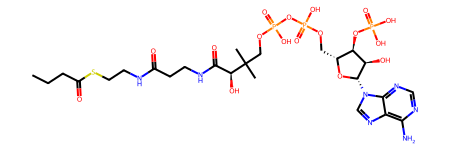

>>> RDK Fingerprint =  <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f5b4a81bf90>
>>> RDK Fingerprint in numpy =  [1 0 1 ... 1 1 1]
>>> RDK Fingerprint in numpy shape =  (2048,)

>>> Morgan Fingerprint =  <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f5b45aa9eb0>
>>> Morgan Fingerprint in numpy :  [0 1 0 ... 0 0 0]
>>> Morgan Fingerprint in numpy shape =  (2048,)


In [56]:
smi_sample = cpds.iloc[123]['SMILES']
print(smi_sample)

mol = Chem.MolFromSmiles(smi_sample)
display(mol)

fingerprint_rdk = Chem.RDKFingerprint(mol)
print(">>> RDK Fingerprint = ", fingerprint_rdk)
fingerprint_rdk_np = np.array(fingerprint_rdk)
print(">>> RDK Fingerprint in numpy = ", fingerprint_rdk_np)
print(">>> RDK Fingerprint in numpy shape = ", fingerprint_rdk_np.shape)

print()

# retrieving Morgan Fingerprint ----------------------------------------------- 
fingerprint_morgan = Chem.rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=2)
print(">>> Morgan Fingerprint = ", fingerprint_morgan)

fingerprint_morgan_np = np.array(fingerprint_morgan)
print(">>> Morgan Fingerprint in numpy : ", fingerprint_morgan_np)
print(">>> Morgan Fingerprint in numpy shape = ", fingerprint_morgan_np.shape)

RDKit supports several fingerprint functions, which outputs could be used for calculating molecular similarity or as the inputs to the downstream machine learning models.

In [57]:
def get_fingerprint(smi):
    mol = Chem.MolFromSmiles(smi)
    fp = Chem.RDKFingerprint(mol)
    return np.array(fp)

In [84]:
pairs_smiles_list = []
for row in tqdm(range(len(pairs))):
    source = pairs.iloc[row]['source']
    source_smi = cpds[cpds['Entry'] == source]['SMILES'].values[0]

    target = pairs.iloc[row]['target']
    target_smi = cpds[cpds['Entry'] == target]['SMILES'].values[0]

    source_smi = get_fingerprint(source_smi)
    target_smi = get_fingerprint(target_smi)
    
    pair_smi = source_smi + target_smi
    pairs_smiles_list.append(pair_smi)

  4%|▍         | 2257/55980 [00:10<04:14, 210.74it/s]


KeyboardInterrupt: 